In [65]:
import asdf
import numpy as np
af = asdf.open('J121930+494052.asdf')
wave = np.array(af['wave'])
wave = np.array(wave, dtype="<f8")
flux = np.array(af['flux'])
flux = np.array(flux, dtype="<f8")
err = np.array(af['err'])
err = np.array(err, dtype="<f8")


(-0.1, 1.1)

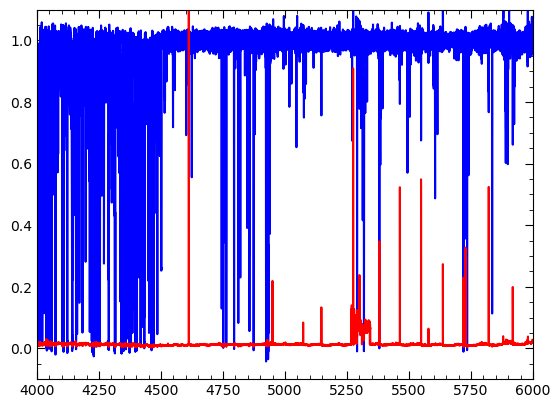

In [66]:
import matplotlib.pyplot as plt
plt.plot(wave,flux,color='b')
plt.plot(wave,err,color='r')
plt.xlim(4000,6000)
plt.ylim(-0.1,1.1)

0.018761192385096638 0.042857160225447596


(-0.1, 1.1)

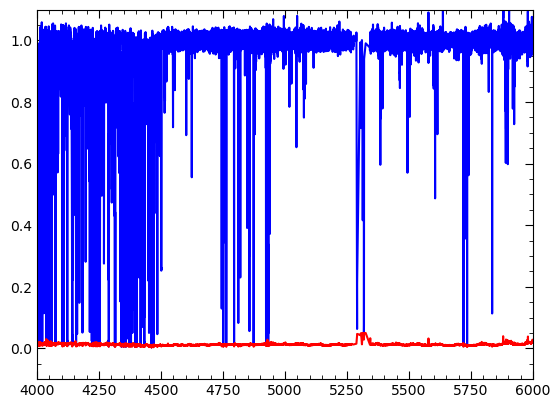

In [68]:
# clean pixels
err_mean = np.mean(err); err_std = np.std(err)
print(err_mean,err_std)
flux1 = flux[(err<0.05)&(flux>0)&(flux>err)]; wave1 = wave[(err<0.05)&(flux>0)&(flux>err)]; err1 = err[(err<0.05)&(flux>0)&(flux>err)]
plt.plot(wave1,flux1,color='b')
plt.plot(wave1,err1,color='r')
plt.xlim(4000,6000)
plt.ylim(-0.1,1.1)

In [69]:
def detect_absorption_lines(wavelengths, flux, threshold=0.9, min_width=5):
    """
    Detect absorption lines in a spectrum and find their midpoints.

    Parameters:
    wavelengths (array-like): Array of wavelength values.
    flux (array-like): Array of normalized flux values corresponding to the wavelengths.
    threshold (float): Flux value below which absorption is detected. Default is 1.0.
    min_width (int): Minimum number of consecutive points below the threshold to be considered significant. Default is 5.

    Returns:
    list of tuples: Each tuple contains the start, end, and midpoint wavelengths of an absorption line.
    """
    absorption_lines = []
    start_idx = None

    for i, f in enumerate(flux):
        if f < threshold:
            if start_idx is None:
                start_idx = i
        else:
            if start_idx is not None:
                if i - start_idx >= min_width:
                    start_wavelength = wavelengths[start_idx]
                    end_wavelength = wavelengths[i-1]
                    midpoint = (start_wavelength + end_wavelength) / 2
                    absorption_lines.append((start_wavelength, end_wavelength, midpoint))
                start_idx = None

    # Handle the case where the absorption line goes till the end of the array
    if start_idx is not None and len(flux) - start_idx >= min_width:
        start_wavelength = wavelengths[start_idx]
        end_wavelength = wavelengths[-1]
        midpoint = (start_wavelength + end_wavelength) / 2
        absorption_lines.append([start_wavelength, end_wavelength, midpoint])

    return absorption_lines

lines=(detect_absorption_lines(wave1,flux1))

(3500.0, 3560.0)

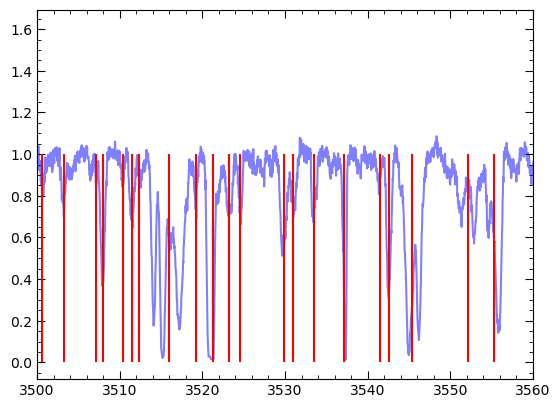

In [85]:
mid = []
for i in range(len(lines)):
    mid.append(lines[i][2])
plt.plot(wave1,flux1,color='blue',alpha=0.5)
plt.vlines(mid,0,1,color='r')
#plt.vlines(lines,0,1,'green')
plt.xlim(3500,3560)

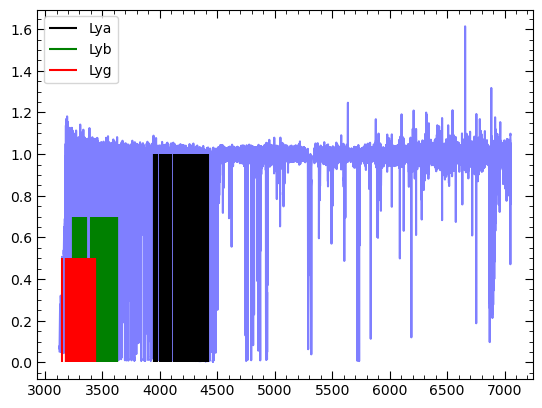

In [99]:
def find_patterns(flux):
    flux = np.array(flux)
    mask = np.ones_like(flux, dtype=bool)  
    patterns = []

    # redshift
    redshift = flux / 1216 - 1

    # Filtering the array and redshift values based on the redshift range
    valid_indices = np.where((redshift > 0) & (redshift < 2.633))[0]
    flux = flux[valid_indices]
    redshift = redshift[valid_indices]
    mask = mask[valid_indices]  

    # Sort array from largest to smallest and get sorted indices
    sorted_indices = np.argsort(flux)[::-1]

    for i in sorted_indices:
        if not mask[i]:
            continue

        z = redshift[i]
        lybeta = 1026 * (1 + z)
        lygamma = 972 * (1 + z)
        wiggle = 100

        # Check for lybeta and lygamma within a range
        found1 = np.where((flux >= lybeta - wiggle) & (flux <= lybeta + wiggle) & mask)[0]
        found2 = np.where((flux >= lygamma - wiggle) & (flux <= lygamma + wiggle) & mask)[0]

        if len(found1) > 0 and len(found2) > 0:
            # Mark the found pattern as masked
            mask[i] = False
            mask[found1[0]] = False
            mask[found2[0]] = False

            # Store the pattern
            patterns.append((z, flux[i], flux[found1[0]], flux[found2[0]]))

    return patterns


res = find_patterns(mid)
red, lya, lyb, lyg  = zip(*res)  
plt.plot(wave1, flux1, color='blue', alpha=0.5)
plt.vlines(lya, 0, 1, 'k', label='Lya')
plt.vlines(lyb, 0, 0.7, 'green', label='Lyb')
plt.vlines(lyg, 0, 0.5, 'red', label='Lyg')
plt.legend()
plt.show()
